In [103]:
# Dependencies
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [2]:
!where python

C:\Users\notes\Anaconda3\envs\trialgan\python.exe
C:\Users\notes\AppData\Local\Programs\Python\Python37\python.exe
C:\Users\notes\AppData\Local\Microsoft\WindowsApps\python.exe


In [3]:
# Import images into numpy array, 'data'.
# Majority of images are shaped (110, 110, 3).
# Images of resolution divisible by 4 is required.
# Ref: https://github.com/loliverhennigh/Crystal-Gems
data = []
img_size = (112, 112, 3)
folder = 'Crystal-Gems/data'

for gem_folder in tqdm(os.listdir(folder)):
    gem_folder_name = os.path.join(folder, gem_folder)
    
    for gem_img in os.listdir(gem_folder_name):
        img = cv2.imread(os.path.join(gem_folder_name, gem_img))
        
        if img is not None and img.shape == (110,110,3):
            # Pad image to (112,112,3)
            padded_img = np.zeros(img_size, dtype=int)
            padded_img[:img.shape[0],:img.shape[1],:img.shape[2]] = img
            data.append(padded_img)

data = np.array(data)
print("data.shape:", data.shape)

100%|████████████████████████████████████████████████████████████████████████████████| 284/284 [00:03<00:00, 78.95it/s]


data.shape: (2937, 112, 112, 3)


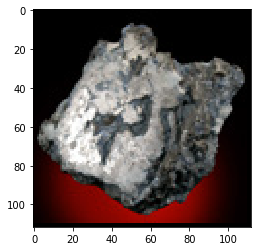

In [4]:
plt.imshow(data[0], cmap='gray')
plt.show()

# DCGAN

In [5]:
# DCGAN
# Ref: https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.models import load_model

import matplotlib.pyplot as plt

import sys

import numpy as np

class DCGAN():
    def __init__(self):
        # Input shape
        self.img_rows = 112
        self.img_cols = 112
        self.channels = 3
        self.img_r = self.img_rows // 4
        self.img_c = self.img_cols // 4
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        model = Sequential()
        
        model.add(Dense(128 * self.img_r * self.img_c, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((self.img_r, self.img_c, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, save_interval=50):

        # Load the dataset
        X_train = data

        # Rescale -1 to 1
        X_train = X_train / 127.5 - 1.
        if len(X_train.shape) == 3:
            X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]

            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator (real classified as ones and generated as zeros)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            # Train the generator (wants discriminator to mistake images as real)
            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)

    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt]*255).astype(np.uint8))
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/gem_%d.png" % epoch)
        plt.close()
        
    # Load pre-trained model
    def load_pretrained_model(self):
        self.discriminator = load_model('models/discriminator.h5')
        self.generator = load_model('models/generator.h5')
        
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
    
        self.discriminator.trainable = False

        valid = self.discriminator(img)
        
        optimizer = Adam(0.0002, 0.5)
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)
        
    # Save model
    def save_model(self):
        self.discriminator.save('models/discriminator.h5')
        self.generator.save('models/generator.h5')

Using TensorFlow backend.


In [6]:
dcgan = DCGAN()
dcgan.load_pretrained_model()  # Total training: 15,150 epochs

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 56, 56, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 56, 56, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 29, 29, 64)        0         
_________________________________________________________________
batch_normalization_1

C:\Users\notes\Anaconda3\envs\trialgan\lib\site-packages\keras\engine\saving.py:327: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '
C:\Users\notes\Anaconda3\envs\trialgan\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [58]:
# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

In [119]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 100
fig_size[1] = 80
plt.rcParams["figure.figsize"] = fig_size

In [117]:
plt.style.use('default')

(20, 100)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

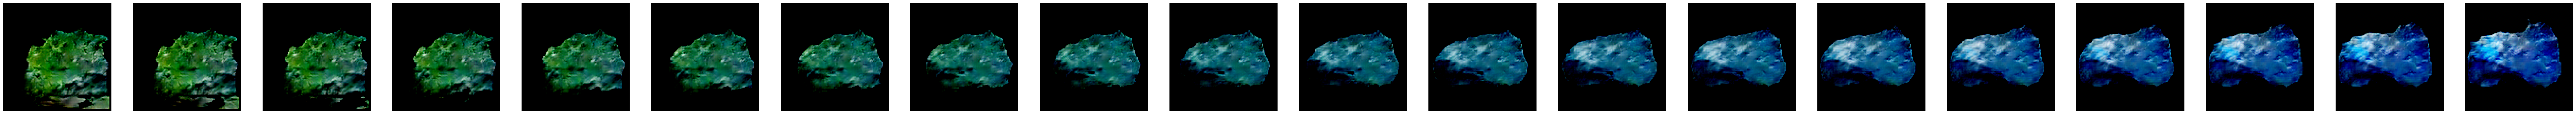

In [124]:
# example of interpolating between generated faces
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from numpy import linspace
from keras.models import load_model
import matplotlib.pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	return z_input

# uniform interpolation between two points in latent space
def interpolate_points(p1, p2, n_steps=10):
	# interpolate ratios between the points
	ratios = linspace(0, 1, num=n_steps)
	# linear interpolate vectors
	vectors = list()
	for ratio in ratios:
		v = (1.0 - ratio) * p1 + ratio * p2
		vectors.append(v)
	return asarray(vectors)

# create a plot of generated images
def plot_generated(examples, n):
	# plot images
	for i in range(n):
		# define subplot
		plt.subplot(1, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()

# generate points in latent space
pts = generate_latent_points(100, 5, n_classes=10)
# interpolate points in latent space
interpolated = interpolate_points(pts[0], pts[1], 20)

# random noise
# noise = np.random.normal(0, 1, (10, 100))

# smooth interpolation
noise = interpolated
print(noise.shape)

gen_imgs = dcgan.generator.predict(noise)
plot_generated(gen_imgs, noise.shape[0])

In [102]:
gen_imgs[0]

array([[[ 0.02551616,  0.10733364,  0.0040031 ],
        [-0.00498334,  0.08140042,  0.01157497],
        [ 0.06548298,  0.12675308,  0.05419534],
        ...,
        [-0.1278637 ,  0.09211697, -0.05065918],
        [-0.99997485, -0.9999809 , -0.9999089 ],
        [-0.99989665, -0.998971  , -0.99951077]],

       [[-0.01614871, -0.00186234, -0.13858058],
        [ 0.04692509,  0.03611059, -0.05513827],
        [ 0.07697711,  0.01430682, -0.08083929],
        ...,
        [ 0.20677619,  0.48505226,  0.44886586],
        [-0.9999961 , -0.9999948 , -0.9999691 ],
        [-0.99999017, -0.9998021 , -0.9998826 ]],

       [[-0.00516449, -0.04408233, -0.04364569],
        [ 0.05241932, -0.0420869 , -0.07657965],
        [ 0.08840062,  0.05338732,  0.06291778],
        ...,
        [ 0.03853986,  0.28477064,  0.22543761],
        [-0.9999951 , -0.99999744, -0.9999815 ],
        [-0.9999956 , -0.9998824 , -0.999952  ]],

       ...,

       [[-0.7560432 , -0.7390171 , -0.807621  ],
        [-0

# WGAN

In [14]:
# DCGAN
# Ref: https://github.com/eriklindernoren/Keras-GAN
from __future__ import print_function, division

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np


class WGAN():
    def __init__(self):
        self.img_rows = 112
        self.img_cols = 112
        self.channels = 3
        self.img_r = self.img_rows // 4
        self.img_c = self.img_cols // 4
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        self.clip_value = 0.01
        optimizer = RMSprop(lr=0.00005)

        # Build and compile the critic
        self.critic = self.build_critic()
        self.critic.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generated imgs
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.critic.trainable = False

        # The critic takes generated images as input and determines validity
        valid = self.critic(img)

        # The combined model  (stacked generator and critic)
        self.combined = Model(z, valid)
        self.combined.compile(loss=self.wasserstein_loss,
            optimizer=optimizer,
            metrics=['accuracy'])

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        model = Sequential()

        model.add(Dense(128 * self.img_r * self.img_c, activation="relu", input_dim=self.latent_dim))
        model.add(Reshape((self.img_r, self.img_c, 128)))
        model.add(UpSampling2D())
        model.add(Conv2D(128, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(UpSampling2D())
        model.add(Conv2D(64, kernel_size=4, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Activation("relu"))
        model.add(Conv2D(self.channels, kernel_size=4, padding="same"))
        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=(self.latent_dim,))
        img = model(noise)

        return Model(noise, img)

    def build_critic(self):

        model = Sequential()

        model.add(Conv2D(16, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=1, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(1))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, sample_interval=50):

        # Load the dataset
#         (X_train, _), (_, _) = mnist.load_data()
        X_train = data
#         X_train = X_train / 127.5 - 1.
#         if len(X_train.shape) == 3:
#             X_train = np.expand_dims(X_train, axis=3)

        # Rescale -1 to 1
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5
        if len(X_train.shape) == 3:
            X_train = np.expand_dims(X_train, axis=3)

        # Adversarial ground truths
        valid = -np.ones((batch_size, 1))
        fake = np.ones((batch_size, 1))

        for epoch in range(epochs):

            for _ in range(self.n_critic):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size)
                imgs = X_train[idx]
                
                # Sample noise as generator input
                noise = np.random.normal(0, 1, (batch_size, self.latent_dim))

                # Generate a batch of new images
                gen_imgs = self.generator.predict(noise)

                # Train the critic
                d_loss_real = self.critic.train_on_batch(imgs, valid)
                d_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
                d_loss = 0.5 * np.add(d_loss_fake, d_loss_real)

                # Clip critic weights
                for l in self.critic.layers:
                    weights = l.get_weights()
                    weights = [np.clip(w, -self.clip_value, self.clip_value) for w in weights]
                    l.set_weights(weights)


            # ---------------------
            #  Train Generator
            # ---------------------

            g_loss = self.combined.train_on_batch(noise, valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, 1 - d_loss[0], 1 - g_loss[0]))

            # If at save interval => save generated image samples
            if epoch % sample_interval == 0:
                self.sample_images(epoch)

    def sample_images(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig("images/mnist_%d.png" % epoch)

In [15]:
wgan = WGAN()
wgan.train(epochs=1000, batch_size=128, sample_interval=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 56, 56, 16)        448       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 56, 56, 16)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 28, 28, 32)        4640      
_________________________________________________________________
zero_padding2d_4 (ZeroPaddin (None, 29, 29, 32)        0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 29, 29, 32)        128       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 29, 29, 32)        0         
__________

C:\Users\notes\Anaconda3\envs\trialgan\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.999728] [G loss: 1.000530]
1 [D loss: 0.999767] [G loss: 1.000562]
2 [D loss: 0.999779] [G loss: 1.000557]
3 [D loss: 0.999791] [G loss: 1.000558]
4 [D loss: 0.999787] [G loss: 1.000559]
5 [D loss: 0.999787] [G loss: 1.000553]
6 [D loss: 0.999786] [G loss: 1.000550]
7 [D loss: 0.999787] [G loss: 1.000532]
8 [D loss: 0.999794] [G loss: 1.000519]
9 [D loss: 0.999798] [G loss: 1.000502]
10 [D loss: 0.999807] [G loss: 1.000464]
11 [D loss: 0.999815] [G loss: 1.000423]
12 [D loss: 0.999829] [G loss: 1.000369]
13 [D loss: 0.999850] [G loss: 1.000306]
14 [D loss: 0.999872] [G loss: 1.000226]
15 [D loss: 0.999901] [G loss: 1.000174]
16 [D loss: 0.999920] [G loss: 1.000114]
17 [D loss: 0.999940] [G loss: 1.000072]
18 [D loss: 0.999954] [G loss: 1.000063]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x00000160EF4242F0> (for post_execute):


KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


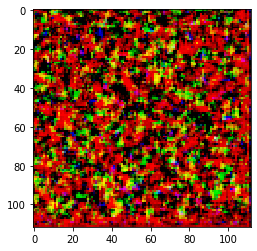

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


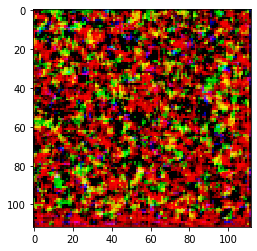

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


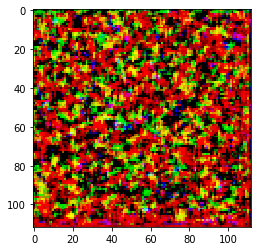

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


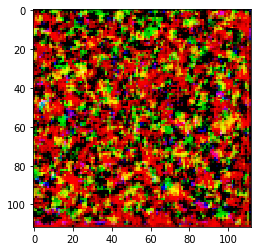

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


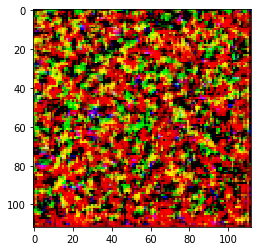

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


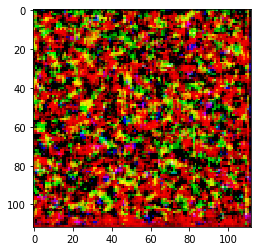

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


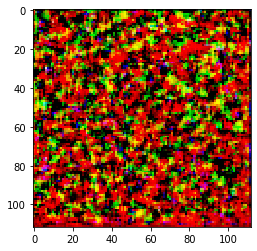

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


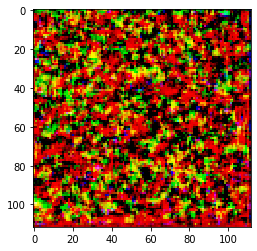

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


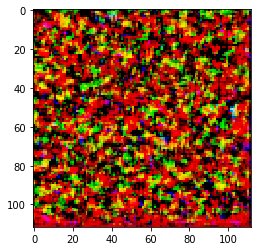

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


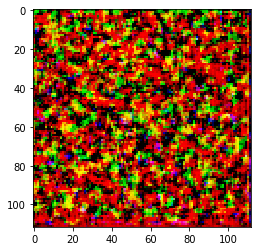

In [16]:
noise = np.random.normal(0, 1, (10, 100))
gen_imgs = wgan.generator.predict(noise)
for i in range(10):
    plt.imshow(gen_imgs[i])
    plt.show()